In [1]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import pandas as pd
import seaborn as sns
import pickle
import math
from IPython.display import clear_output
import numpy as np
import re

sns.set_context("notebook", font_scale=1.25)
 
file_path = "turl_test_2k_prompts_50_unique.jsonl"
device = torch.device("mps")
prefix = 'pickle'

In [2]:
# https://github.com/ipython-contrib/jupyter_contrib_nbextensions/pull/1663

In [3]:
from io import BytesIO

def fix(map_loc):
    # Closure rather than a lambda to preserve map_loc 
    return lambda b: torch.load(BytesIO(b), map_location=map_loc)

class MappedUnpickler(pickle.Unpickler):
    # https://github.com/pytorch/pytorch/issues/16797#issuecomment-633423219

    def __init__(self, *args, map_location='cpu', **kwargs):
        self._map_location = map_location
        super().__init__(*args, **kwargs)

    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return fix(self._map_location)
        else: 
            return super().find_class(module, name)

def mapped_loads(s, map_location='cpu'):
    bs = BytesIO(s)
    unpickler = MappedUnpickler(bs, map_location=map_location)
    return unpickler.load()

In [4]:
# prompt formatting

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input_seg}\n\n### Question:\n{question}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

def generate_prompt(instruction, question, input_seg=None):
    question += " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    if input_seg:
        return PROMPT_DICT["prompt_input"].format(instruction=instruction, input_seg=input_seg, question=question)
    else:
        return PROMPT_DICT["prompt_no_input"].format(instruction=instruction)

In [5]:
# load questions (to be removed)

with open(file_path, "r", encoding="utf-8") as f:
    prompts = [json.loads(line) for line in f]

In [6]:
import os
import pickle
from copy import copy, deepcopy
import zipfile

pre_keys = ['pre_output_proba_topn',
 'pre_output_proba_topk',
 'pre_output_true_entropies',
 'pre_output_layers_kl']

run = 0
outlist = []

for file in os.listdir(prefix):
    if file.endswith('zip'):
        print(file)
        archive = zipfile.ZipFile(os.path.join(prefix, file), 'r')
        for pid, single_file in enumerate(tqdm(archive.filelist)):
            
            if single_file.filename.startswith('_') or single_file.filename.startswith('.'): continue
                
            # item = pickle.loads(archive.read(single_file.filename))
            item = mapped_loads(archive.read(single_file.filename))
            
            for i, _ in enumerate(item["post_output_sequences"]):
                
                item_ = copy(item)
                item_["post_output_sequences"] = item["post_output_sequences"][i]
                
                item_["post_output_proba_topn"] = item["post_output_proba_topn"][i]
                item_["post_output_proba_topk"] = item["post_output_proba_topk"][i]
                item_["post_output_true_entropies"] = item["post_output_true_entropies"][i] 

                item_["post_output_layers_kl"] = item["post_output_layers_kl"][i]
                item_["transition_scores_s"] = item["transition_scores_s"][i]
                item_["transition_scores_l"] = item["transition_scores_l"][i]

                item_["run"] = run + i
                
                outlist.append(item_)
                
                # whatever is generated for pre_ is propagated only to the first run
                if i == 0:
                    for k in pre_keys: item.pop(k, None)
      
        run = run + i + 1 # next zip file

len(outlist)

llama3.1-8b.zip


  0%|                                                  | 0/1502 [00:00<?, ?it/s]/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_29899/3807410893.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

15020

In [7]:
# prefix, model_name = './tablellama-complete/', "osunlp/TableLlama"
# prefix, model_name = './gemma-9b-complete/', "google/gemma-2-9b-it"

model_name = item['args']['model_name'] # get model from last processed item
print(model_name)

if model_name.startswith("osunlp"):
    config = transformers.AutoConfig.from_pretrained(model_name)

    orig_ctx_len = getattr(config, "max_position_embeddings", None)
    context_size = 8192
    if orig_ctx_len and context_size > orig_ctx_len:
            scaling_factor = float(math.ceil(context_size / orig_ctx_len))
            config.rope_scaling = {"type": "linear", "factor": scaling_factor}

    tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                              model_max_length=(context_size if context_size > orig_ctx_len else orig_ctx_len),
                                              padding_side="left", 
                                              use_fast=False)

else:
    config = transformers.AutoConfig.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

meta-llama/Llama-3.1-8B-Instruct


### check output against ground truth

In [148]:
%%time

# show results

c=0
t=0
h=0

truth = []
outseq = []

pdbg = None

for idx, p in enumerate(outlist):
    
    if idx%100==0: 
        clear_output(wait=True)
        print(idx, end='\r')
    c+=1
    pdbg = p
    
    # in
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
        
    # computed
    # post_output_scores = p['post_output_scores']
    post_output_sequences = p['post_output_sequences']
    
    # bases
    baseid = len(inputs["input_ids"][0]) + 1
    endid = len(post_output_sequences[0])
    # lookout
    generated_ids = post_output_sequences
    generated_text = tokenizer.decode(generated_ids[0][baseid:endid], skip_special_tokens=True)
    # print
    # print(generated_text)
    # print(p['output'])
    # print('\n')
    #test
    
    # replacement due to tablellama "hallucinations"
    a = generated_text.replace('[DESCRIPTION]', '[DESC]').lower().strip()
    a = " ".join(a.split(" "))
    if len(a) < 1: 
        print("SOMETHING WENT HORRIBLY WRONG, GIVING UP")
        break

    b = p['output'].lower().strip()
    b = " ".join(b.split(" "))
    # correct
    correct = False
    hallucinated = False
    if ((a in b) or (b in a) or (b.startswith(a)) or (a.startswith(b))) and (('desc' in a) and ('type' in a)): 
        correct = True
        t+=1
    # hallucinated
    elif a not in prompt.lower().strip(): 
        h+=1
        hallucinated = True
    # incorrect
    else:
        pass
        #print(generated_text)
        #print(p['output'])
        #print('\n')
        # print(prompt)
        # print('\n')
        
    # loose correctness
    _, three_ = b.split('[type]')
    one_, two_ = _.split('[desc]')
    one_ = one_.replace('<', '').replace('>', '').replace(']', '').replace('[', '').strip()
    two_ = two_.replace('<', '').replace('>', '').replace(']', '').replace('[', '').strip()
    three_ = three_.replace('<', '').replace('>', '').replace(']', '').replace('[', '').strip()
    
    loosely_correct = False
    matched_string = None
    try:                  
        regex = re.compile(r'^.{0,2}(' + re.escape(one_) + r'.{0,8}' + re.escape(two_) + r'.{0,8}' + re.escape(three_) + r')')
        match = regex.search(a)
        if match: 
            loosely_correct = True
            matched_string = match.group(1)
    except Exception as e:
        pass# if it fails, default

    truth.append((p['run'], p['pid'], correct, hallucinated, loosely_correct))
    outseq.append((p['run'], p['pid'], a, post_output_sequences, b, matched_string))


CPU times: user 50.1 s, sys: 5.37 s, total: 55.5 s
Wall time: 1min 3s


In [149]:
len(inputs.input_ids[0]), len(post_output_sequences[0])

(3768, 3832)

In [150]:
# true, hallucinated, counted
# (3702, 26, 5120) tablellama old
# (11190, 880, 14770) gemma 9b
t, h, c

(4676, 10251, 15020)

In [151]:
# correct answers rate, hallucinated answers rate
t/c, h/c

(0.31131824234354194, 0.6824900133155792)

In [152]:
truth = pd.DataFrame(truth, columns=['run', 'pid', 'correct', 'hallucinated', 'loosely_correct'])

In [153]:
corec = truth.groupby('pid').correct.mean()

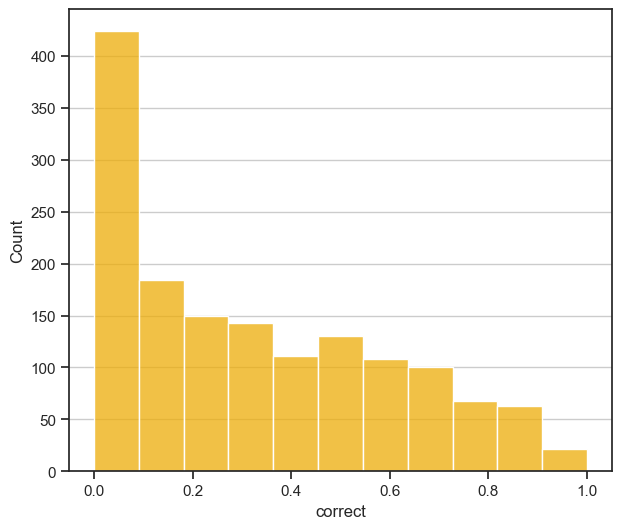

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 6))

sns.histplot(corec, bins=corec.nunique(), color=Prism_10.mpl_colors[5])

ax.yaxis.grid(True)

plt.show()

In [155]:
# probability mass for "convinced" prediction
(np.isclose(corec, 0.) | np.isclose(corec, 1.)).sum() / corec.shape[0]

0.296271637816245

In [156]:
# how many "changed at least once"
((corec>0.) & (corec<1.)).sum() / corec.shape[0]

0.703728362183755

In [157]:
# again but without hallucinated

truth_ = truth[(~truth.hallucinated)].copy()
truth_['true_err'] = truth_.correct

corec_ = truth_.groupby('pid').true_err.mean()

((corec_>0.) & (corec_<1.)).sum() / corec_.shape[0]

0.030973451327433628

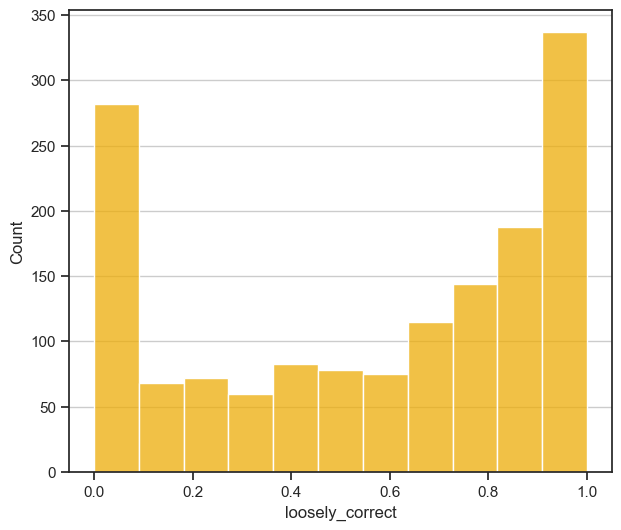

In [158]:
# loosely correct

import seaborn as sns
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

sns.set_theme(style="ticks")

corek = truth.groupby('pid').loosely_correct.mean()

f, ax = plt.subplots(figsize=(7, 6))

sns.histplot(corek, bins=corek.nunique(), color=Prism_10.mpl_colors[5])

ax.yaxis.grid(True)

plt.show()

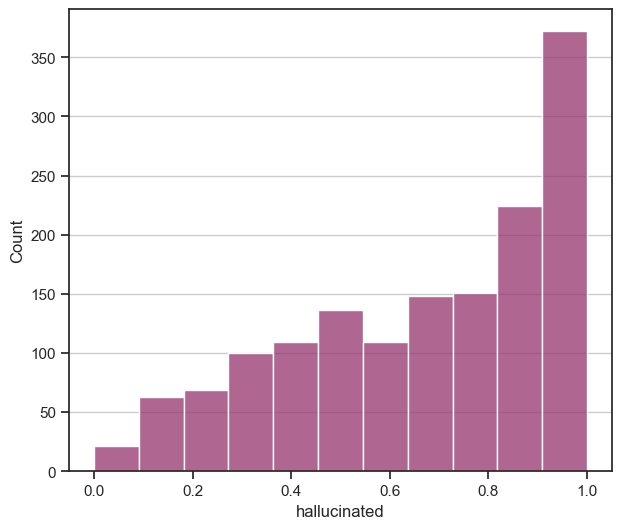

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 6))

sns.histplot(truth.groupby('pid').hallucinated.mean(), bins=corec.nunique(), color=Prism_10.mpl_colors[8])

ax.yaxis.grid(True)

plt.show()

In [160]:
# how many hallucinated
(truth.groupby('pid').hallucinated.mean()>0.).sum() / truth.pid.nunique()

0.9860186418109188

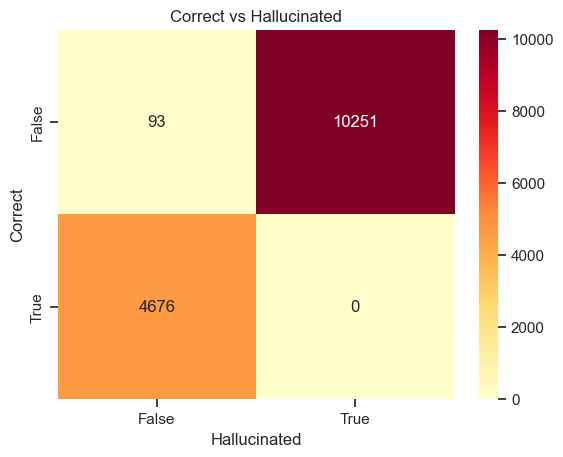

In [161]:
contingency = pd.crosstab(truth.correct, truth.hallucinated)

sns.heatmap(contingency, annot=True, fmt="d", cmap="YlOrRd")

plt.title("Correct vs Hallucinated")
plt.xlabel("Hallucinated")
plt.ylabel("Correct")
plt.show()

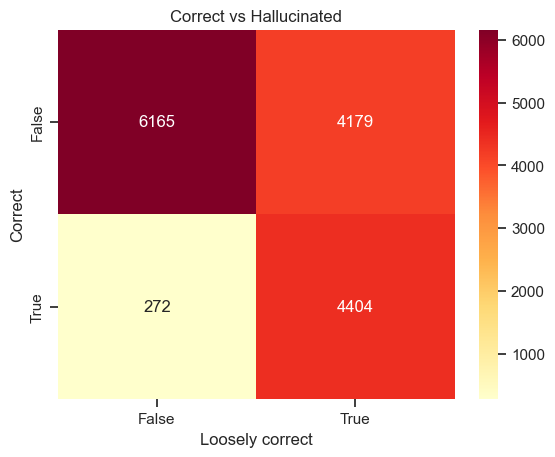

In [162]:
contingency = pd.crosstab(truth.correct, truth.loosely_correct)

sns.heatmap(contingency, annot=True, fmt="d", cmap="YlOrRd")

plt.title("Correct vs Hallucinated")
plt.xlabel("Loosely correct")
plt.ylabel("Correct")
plt.show()

In [225]:
# answers
answers = pd.DataFrame(outseq, columns=['run', 'pid', 'answer', 'answer_seq', 'right_answer', 'regex_match'])
answers.answer = answers.answer.str[:-1]

In [226]:
# min and max number of unique answers
answers.groupby('pid').answer.nunique().min(), answers.groupby('pid').answer.nunique().max()

(6, 10)

In [227]:
answers

,run,pid,answer,answer_seq,right_answer,regex_match
0,0,129,"netball [desc] ball sport [type] type of sport] \n\nthe final answer is: netball [desc] ball sport [type] type of sport] . i hope it is correct. in the table, row 0 has a column named col3 with ...","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport
1,1,129,netball [desc] ball sport [type] type of sport\n\n### prompt response:\n\nthe correct referent entity for the entity mention 'netball' is 'netball [desc] ball sport [type] type of sport'. i selec...,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport
2,2,129,"netball [desc] ball sport [type] type of sport] ### step 1: identify the task\nthe task is an entity linking task, where we need to link the selected entity mention ""netball"" to the correct refer...","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport
3,3,129,ball [desc] ball sport [type] type of sport]. ### response:\nnetball [desc] ball sport [type] type of sport]. was chosen as the most appropriate referent entity for the given mention. \n\nhowever...,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<netball [desc] ball sport [type] type of sport>,None
4,4,129,">netball [desc] ball sport [type] type of sport> ### step 1: analyzing the table\nthe table contains a list of athletes and their respective sports, with a column name for 'netball' being col3.\n...","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport
...,...,...,...,...,...,...
15015,5,599,"<philippe sutherland [desc] french basketball player [type] sport cyclist]> doesn't match the entity mention 'sutherland'. there is a <sutherland [desc] suburb of sydney, australia [type] suburb> ...","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...","<sutherland [desc] former state electoral district of new south wales, australia [type] electoral district of new south wales>",None
15016,6,599,"sutherland shire [desc] local government area in new south wales, australia [type] local government area of new south wales] ### step 1: analyze the entity mention and the given context\nthe enti...","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...","<sutherland [desc] former state electoral district of new south wales, australia [type] electoral district of new south wales>",None
15017,7,599,the selected entity mention in the table cell is: 'sutherland'. the column name for 'sutherland' is col2. the referent entity candidates are:\nthe correct referent entity for the entity mention ’s...,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 26

In [165]:
# wrong answers

import numpy as np
def fun (a,b):
    return a.startswith(b) or b.startswith(a)

foon = np.vectorize(fun)
aoh = pd.Series(foon(answers.answer, answers.right_answer), index=answers.index)

answers[~aoh]

,run,pid,answer,answer_seq,right_answer,regex_match
0,0,129,"netball [desc] ball sport [type] type of sport] \n\nthe final answer is: netball [desc] ball sport [type] type of sport] . i hope it is correct. in the table, row 0 has a column named col3 with ...","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport
1,1,129,netball [desc] ball sport [type] type of sport\n\n### prompt response:\n\nthe correct referent entity for the entity mention 'netball' is 'netball [desc] ball sport [type] type of sport'. i selec...,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport
2,2,129,"netball [desc] ball sport [type] type of sport] ### step 1: identify the task\nthe task is an entity linking task, where we need to link the selected entity mention ""netball"" to the correct refer...","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport
3,3,129,ball [desc] ball sport [type] type of sport]. ### response:\nnetball [desc] ball sport [type] type of sport]. was chosen as the most appropriate referent entity for the given mention. \n\nhowever...,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<netball [desc] ball sport [type] type of sport>,None
4,4,129,">netball [desc] ball sport [type] type of sport> ### step 1: analyzing the table\nthe table contains a list of athletes and their respective sports, with a column name for 'netball' being col3.\n...","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport
...,...,...,...,...,...,...
15015,5,599,"<philippe sutherland [desc] french basketball player [type] sport cyclist]> doesn't match the entity mention 'sutherland'. there is a <sutherland [desc] suburb of sydney, australia [type] suburb> ...","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...","<sutherland [desc] former state electoral district of new south wales, australia [type] electoral district of new south wales>",None
15016,6,599,"sutherland shire [desc] local government area in new south wales, australia [type] local government area of new south wales] ### step 1: analyze the entity mention and the given context\nthe enti...","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...","<sutherland [desc] former state electoral district of new south wales, australia [type] electoral district of new south wales>",None
15017,7,599,the selected entity mention in the table cell is: 'sutherland'. the column name for 'sutherland' is col2. the referent entity candidates are:\nthe correct referent entity for the entity mention ’s...,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 26

In [166]:
pd.set_option('max_colwidth', 200)

In [167]:
# correct but not loosely correct?
gg = pd.merge(truth, answers, on=['run', 'pid'], how='inner')
gg[(~gg.loosely_correct) & (gg.correct)]

,run,pid,correct,hallucinated,loosely_correct,answer,answer_seq,right_answer,regex_match
47,7,125,True,False,False,rushen [desc] one of the six sheadings of the isle of man [type] sheading>. <rushen [desc] parish in the sheading of the same name in the isle of man [type] parish of the isle of man>. <rushen,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<rushen [desc] parish in the sheading of the same name in the isle of man [type] parish of the isle of man>,None
292,2,537,True,False,False,southeast [desc] wikimedia disambiguation page [type] wikimedia disambiguation page> is not correct.\nthe correct referent entity for the entity mention 'southeast' is <southeast [desc] region of ...,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<southeast [desc] region of vietnam [type] region of vietnam>,None
300,0,373,True,False,False,<ukraine [desc] scientific article published in 1931 [type] scholarly article> answer: <ukraine [desc] country in eastern europe [type] unitary state>. answer with the correct candidate only. the ...,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<ukraine [desc] country in eastern europe [type] unitary state>,None
378,8,1429,True,False,False,<tom jones [desc] 1917 british comedy film directed by edwin j. collins [type] film> \n#### or <tom jones [desc] 1963 british adventure comedy film directed by tony richardson [type] film> \n#### ...,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<tom jones [desc] 1963 british adventure comedy film directed by tony richardson [type] film>,None
455,5,40,True,False,False,"< stadion [desc] none [type] street > # correct answer is the candidate <rat verlegh stadion [desc] multi-purpose stadium in breda, netherlands [type] association football venue> however as per ...","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...","<rat verlegh stadion [desc] multi-purpose stadium in breda, netherlands [type] association football venue>",None
...,...,...,...,...,...,...,...,...,...
14474,4,1465,True,False,False,"> <irish [desc] language native to ireland [type] modern language>> \n\n### reasoning skill:\nthis task requires the ability to identify the correct entity referent for a given mention, in this ca...","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<irish [desc] language native to ireland [type] modern language>,None
14528,8,370,True,False,False,"ay, i can do that!\nthe correct referent entity is <yaracuyanos fc [desc] association football club [type] association football club>. i have chosen this candidate based on the name of the team a...","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<yaracuyanos fc [desc] association football club [type] association football club>,None
14584,4,1312,True,False,False,<preferred health network [desc] healthcare service provider and medical facility manager [type] none> ### response 2 \n<wichita open supporting wichita's youth [desc] professional golf tournament...,"[[128000, 39314, 

In [168]:
# only loosely correct
gg = pd.merge(truth, answers, on=['run', 'pid'], how='inner')
gg[(gg.loosely_correct) & (~gg.correct)].drop_duplicates(subset='pid')

,run,pid,correct,hallucinated,loosely_correct,answer,answer_seq,right_answer,regex_match
0,0,129,False,True,True,"netball [desc] ball sport [type] type of sport] \n\nthe final answer is: netball [desc] ball sport [type] type of sport] . i hope it is correct. in the table, row 0 has a column named col3 with ...","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport
22,2,1130,False,True,True,shenay perry [desc] american tennis player [type] tennis player. \nnote: please see the description on the right of the image below for the meaning of different types of links. \n\nthis image is a...,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<shenay perry [desc] american tennis player [type] tennis player>,shenay perry [desc] american tennis player [type] tennis player
34,4,344,False,True,True,minnesota [desc] state of the united states of america [type] u.s. state]. \n### the end. ### this response was generated using a neural network-based model. it selects the entity mention 'minne...,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<minnesota [desc] state of the united states of america [type] u.s. state>,minnesota [desc] state of the united states of america [type] u.s. state
50,0,1364,False,True,True,toyota [desc] japanese multinational automotive manufacturer [type] commercial organization]> ### note: please do not include the closing parenthesis in the response. just the description verbati...,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<toyota [desc] japanese multinational automotive manufacturer [type] commercial organization>,toyota [desc] japanese multinational automotive manufacturer [type] commercial organization
70,0,47,False,True,True,elmer fudd [desc] warner bros. cartoon character [type] looney tunes character. <br> the final answer is: elmer fudd [desc] warner bros. cartoon character [type] looney tunes character. <br> th...,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<elmer fudd [desc] warner bros. cartoon character [type] looney tunes character>,elmer fudd [desc] warner bros. cartoon character [type] looney tunes character
...,...,...,...,...,...,...,...,...,...
14932,2,873,False,True,True,"<trinity lutheran church [desc] church in elloree, south carolina [type] church building]> ### step 1: identify the task and the entity to be linked.\nthe task is to link the entity mention ""trin...","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...","<trinity lutheran church [desc] church in elloree, south carolina [type] church building>","trinity lutheran church [desc] church in elloree, south carolina [type] church building"
14940,0,83,False,True,True,walter e. powell [desc] american politician (1931-2020) [type] teacher,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<walter e. powell [desc] american politician (1931-2020) [type] teacher>,walter e. powell [desc] american po

### sequence components alignment
### (build "segments" for each sequence)

In [169]:
def is_sublist(c, m, label):
    if not c: return False
    if not m or len(c) > len(m): return False

    for i in range(len(m) - len(c) + 1):
        if m[i:i+len(c)] == c:
            return (i, i + len(c), label)
    return False

In [170]:
# %%time

checks = []
alls = set()

for idx, p in enumerate(outlist):
    if idx%100==0: 
        clear_output(wait=True)
        print(idx, end='\r')
    
    run = p['run']
    pid = p['pid']
    
    alls.add(p['table'])
    
    # this is the generated sequence
    output_seq = p['post_output_sequences'][0]
    
    # overall prompt sequence
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    prompt_seq = tokenizer(prompt, return_tensors="pt")
    prompt_seq = prompt_seq['input_ids'][0].numpy().tolist()

    # subsequences
    instruction_seq = tokenizer(p["instruction"], return_tensors="pt")
    instruction_seq = instruction_seq['input_ids'][0].numpy().tolist()

    question_seq = tokenizer(p["question"], return_tensors="pt")
    question_seq = question_seq['input_ids'][0].numpy().tolist()

    input_seq = tokenizer(p["input"], return_tensors="pt")
    input_seq = input_seq['input_ids'][0].numpy().tolist()

    postilla = " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    postilla += "\n\n### Response:"
    postilla_seq = tokenizer(postilla, return_tensors="pt")
    postilla_seq = postilla_seq['input_ids'][0].numpy().tolist()
    
    # subseq matching
    if model_name.startswith('osunlp'): start_tok = 2
    else: start_tok = 1
    
    instruction_match = is_sublist(instruction_seq[start_tok:], output_seq, 'instruction')
    if not instruction_match: instruction_match = is_sublist(instruction_seq[start_tok:-1], output_seq, 'instruction')
    input_match = is_sublist(input_seq[start_tok:], output_seq, 'input')
    if not input_match: input_match = is_sublist(input_seq[start_tok:-1], output_seq, 'input')
    question_match = is_sublist(question_seq[start_tok:], output_seq, 'question')
    if not question_match: question_match = is_sublist(question_seq[start_tok:-1], output_seq, 'question')
    postilla_match = is_sublist(postilla_seq[start_tok:], output_seq, 'postilla')
    
    # boundaries are inclusive
    checks.append((run, pid, 0, instruction_match[0] - 1, 'preamble')) # preamble
    checks.append((run, pid, instruction_match[0]) + instruction_match[1:])
    checks.append((run, pid, instruction_match[1] + 1) + input_match[1:]) # sew to preceding
    # checks.append((run, pid, input_match[1] + 1) + question_match[1:]) # sew to preceding
    checks.append((run, pid, input_match[1] + 1) + (postilla_match[0]-1, 'question')) # sew to both   
    
    # CORRECT skipped the last token in pre_
    checks.append((run, pid, postilla_match[0], len(prompt_seq) - 1, 'postilla')) # stretch postilla until the end of the prompt
    checks.append((run, pid, len(prompt_seq) , len(output_seq) - 1, 'generated')) # assume everything else is generated    
    
    # COMPATIBILITY with crippled cache
    # checks.append((run, pid, postilla_match[0], len(prompt_seq) - 2, 'postilla'))
    # checks.append((run, pid, len(prompt_seq)-1 , len(output_seq) - 2, 'generated')) # assume everything else is generated    
    
    
    # before caching dirty trick
    # checks.append((run, pid, postilla_match[0] + 1, len(prompt_seq) - 1, 'postilla')) # stretch postilla until the end of the prompt
    # checks.append((run, pid, len(prompt_seq), len(output_seq) - 1, 'generated')) # assume everything else is generated
    
    #print(len(prompt_seq), len(output_seq) - 1)


In [171]:
# check the checks (must be False)
'False' in checks

False

In [172]:
segments = pd.DataFrame(checks, columns = ['run', 'pid', 'start', 'end', 'segment'])

In [173]:
segments['seq'] = segments.segment.map({'preamble': 0, 'instruction': 1, 'input': 2, 'question': 3, 'postilla': 4, 'generated': 5})

In [174]:
segments['length'] = segments.end - segments.start + 1

In [175]:
segments

,run,pid,start,end,segment,seq,length
0,0,129,0,30,preamble,0,31
1,0,129,31,125,instruction,1,95
2,0,129,126,1987,input,2,1862
3,0,129,1988,2961,question,3,974
4,0,129,2962,3021,postilla,4,60
...,...,...,...,...,...,...,...
90115,9,599,31,125,instruction,1,95
90116,9,599,126,2586,input,2,2461
90117,9,599,2587,3707,question,3,1121
90118,9,599,3708,3767,postilla,4,60


### debug alignment here

In [176]:
segments[(p['pid'] == segments['pid']) & (segments['run']==0)]

,run,pid,start,end,segment,seq,length
90060,0,599,0,30,preamble,0,31
90061,0,599,31,125,instruction,1,95
90062,0,599,126,2586,input,2,2461
90063,0,599,2587,3707,question,3,1121
90064,0,599,3708,3767,postilla,4,60
90065,0,599,3768,3831,generated,5,64


In [177]:
# debug
p = outlist[0]
prompt = generate_prompt(p["instruction"], p["question"], p["input"])
prompt_seq = tokenizer(prompt, return_tensors="pt")

In [178]:
myids = segments[(p['pid'] == segments['pid']) & (segments['run']==0) & (segments['segment']=='preamble')]
tokens = tokenizer.batch_decode(prompt_seq["input_ids"][0][myids.start.iloc[0]:myids.end.iloc[0]+1], skip_special_tokens=False, clean_up_tokenization_spaces=True)

''.join(tokens)

'<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\n'

In [179]:
myids = segments[(p['pid'] == segments['pid']) & (segments['run']==0) & (segments['segment']=='instruction')]

tokens = tokenizer.batch_decode(prompt_seq["input_ids"][0][myids.start.iloc[0]:myids.end.iloc[0]+1], skip_special_tokens=False, clean_up_tokenization_spaces=True)
''.join(tokens)

'This is an entity linking task. The goal for this task is to link the selected entity mention in the table cells to the entity in the knowledge base. You will be given a list of referent entities, with each one composed of an entity name, its description and its type. Please choose the correct one from the referent entity candidates. Note that the Wikipedia page, Wikipedia section and table caption (if any) provide important information for choosing the correct referent entity.\n\n'

In [180]:
myids = segments[(p['pid'] == segments['pid']) & (segments['run']==0) & (segments['segment']=='input')]

tokens = tokenizer.batch_decode(prompt_seq["input_ids"][0][myids.start.iloc[0]:myids.end.iloc[0]+1], skip_special_tokens=False, clean_up_tokenization_spaces=True)
''.join(tokens)

'### Input:\n[TLE] London Youth Games Hall of Fame. Inductees [TAB] col: |year|name|borough|sport|notes| row 0: |2009|Steve Backley|Bexley|Athletics|Twice broke the javelin world record and is the only British track and field athlete to have won medals at three successive Olympic Games. He has also won two World Championship silvers, four European Championship golds and three Commonwealth Games golds.| row 1: |2009|Linford Christie|Hammersmith and Fulham|Athletics|Competed at the first ever London Youth Games in 1977 for Hammersmith & Fulham where he was only selected for the relay. He went on to enjoy one of the most successful careers of any British athlete, crowned by his victory in the men’s 100m at the 1992 Olympic Games. He is the only man ever to simultaneously hold the Olympic, World, European and Commonwealth 100m titles.| row 2: |2009|Luol Deng|Croydon|Basketball|Competed for Croydon at the London Youth Games before going on to become one of the world’s premier basketball pla

In [181]:
myids = segments[(p['pid'] == segments['pid']) & (segments['run']==0) & (segments['segment']=='question')]

tokens = tokenizer.batch_decode(prompt_seq["input_ids"][0][myids.start.iloc[0]:myids.end.iloc[0]+1], skip_special_tokens=False, clean_up_tokenization_spaces=True)
''.join(tokens)

"### Question:\nThe selected entity mention in the table cell is: 'Netball'. The column name for 'Netball' is col3. The referent entity candidates are:<Category:2001 in netball [DESC] Wikimedia category [TYPE] Wikimedia category>,<Category:2014 in netball [DESC] Wikimedia category [TYPE] Wikimedia category>,<netball in the Americas [DESC] None [TYPE] sport in a geographic region>,<Greater Western Sydney Giants Netball [DESC] netball team in Australia [TYPE] sports team>,<Fast5 [DESC] five-a-side netball [TYPE] None>,<Sirens [DESC] netball team [TYPE] sports team>,<Netball Namibia [DESC] None [TYPE] umbrella organization>,<netballer [DESC] sportsperson that plays netball [TYPE] profession>,<Category:Giants Netball [DESC] Wikimedia category [TYPE] Wikimedia category>,<netball position [DESC] None [TYPE] None>,<Template:Infobox netball biography [DESC] Wikipedia template page [TYPE] Wikimedia infobox template>,<1999 World Netball Championships [DESC] 1999 Netball Championships in Christch

In [182]:
myids = segments[(p['pid'] == segments['pid']) & (segments['run']==0) & (segments['segment']=='postilla')]

tokens = tokenizer.batch_decode(prompt_seq["input_ids"][0][myids.start.iloc[0]:myids.end.iloc[0]+1], skip_special_tokens=False, clean_up_tokenization_spaces=True)
''.join(tokens)

' Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information.\n\n### Response:'

In [183]:
myids = segments[(p['pid'] == segments['pid']) & (segments['run']==0) & (segments['segment']=='generated')]

tokens = tokenizer.batch_decode(prompt_seq["input_ids"][0][myids.start.iloc[0]:myids.end.iloc[0]+1], skip_special_tokens=False, clean_up_tokenization_spaces=True)
''.join([t.replace('▁', '') for t in tokens])

''

### segment description

In [184]:
avg_seq_widths = segments.groupby(['segment', 'seq']).length.agg(['mean', 'std', 'min', 'max']).reset_index().sort_values('seq')
avg_seq_widths = avg_seq_widths.rename(columns = {'mean': 'avg_length', 
                                                  'std': 'std_length', 
                                                  'min': 'min_length',
                                                  'max': 'max_length'})
avg_seq_widths['avg_length_rel'] = avg_seq_widths['avg_length'] / avg_seq_widths['avg_length'].sum()
avg_seq_widths['avg_cumlen'] = avg_seq_widths['avg_length_rel'].cumsum() 
avg_seq_widths

,segment,seq,avg_length,std_length,min_length,max_length,avg_length_rel,avg_cumlen
4,preamble,0,31.000000,0.000000,31,31,0.013348,0.013348
2,instruction,1,95.000000,0.000000,95,95,0.040906,0.054254
1,input,2,976.217710,690.497871,113,3038,0.420345,0.474599
5,question,3,1099.618509,200.531650,234,2618,0.473480,0.948078
3,postilla,4,60.000000,0.000000,60,60,0.025835,0.973914
0,generated,5,60.583688,11.251662,5,64,0.026086,1.000000


<Axes: xlabel='length', ylabel='Count'>

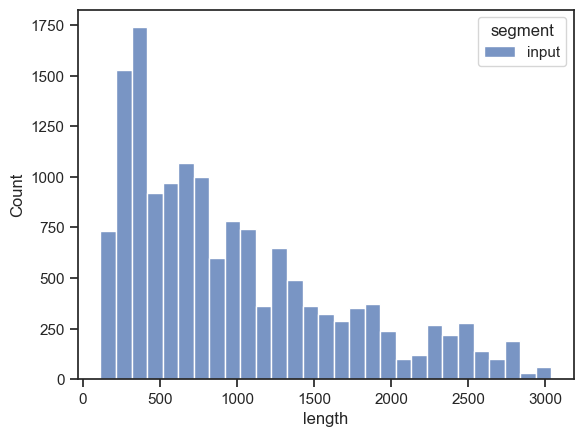

In [185]:
sns.histplot(segments[segments.segment=='input'], x='length', hue='segment', multiple='dodge', binwidth=100)

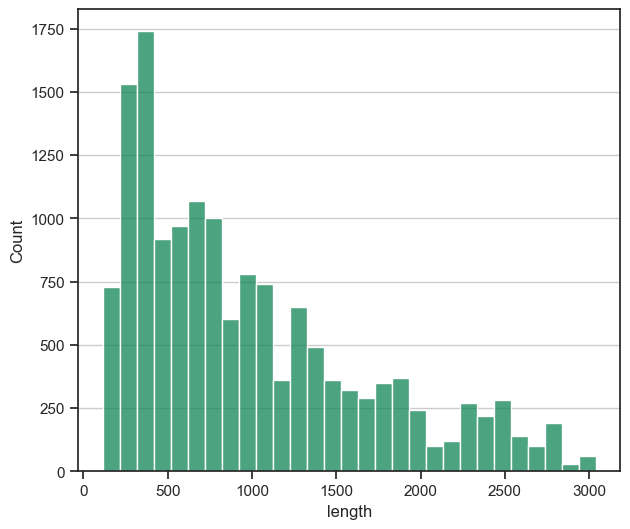

In [186]:
import seaborn as sns
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 6))

sns.histplot(segments[segments.segment=='input'], x='length', color=Prism_10.mpl_colors[3], multiple='dodge', binwidth=100)

ax.yaxis.grid(True)

plt.show()

In [187]:
# Define background regions [(start, end, color, label)] based on the cumulative sections spans (for the first viz above)

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

myl = avg_seq_widths.avg_cumlen.to_list()
sections = ['preamble', 'instruction', 'input', 'question', 'postilla', 'generated']


first = (0., myl[0], palette[0], sections[0])
background_regions = [first]

for z1, z2, l, i in zip(myl, myl[1:], sections[1:], range(len(myl))):
    background_regions.append((z1,z2, palette[i+1], l))

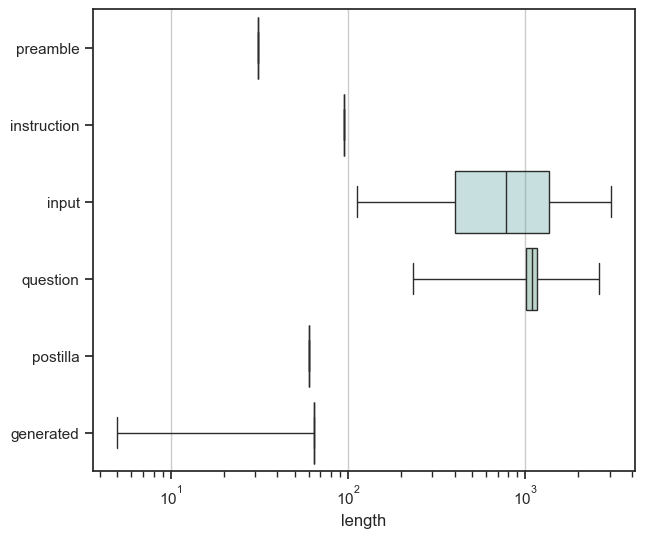

In [188]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

# Plot the orbital period with horizontal boxes
sns.boxplot(
    segments, x="length", y="segment", hue="segment",
    whis=[0, 100], palette=[b[2] for b in background_regions]
)

for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

ax.xaxis.grid(True)
ax.set(ylabel="")

plt.show()

### collect observables

In [189]:
# outlist[0]['post_output_layers_kl'] ha dimensione n layer x m token generati
# outlist[0]['transition_scores_s'] ha dimensione m token generati

In [190]:
%%time

shapes = []

# for each prompt
for i, p in enumerate(outlist):
    # for each token
    run = p['run']
    pid = p['pid']
    
    # append all forward data (for run0 only)   
    if 'pre_output_proba_topn' in p:
        transpose_kl_pre = list(map(list, zip(*p['pre_output_layers_kl'])))
        for j, pp in enumerate(p['pre_output_proba_topn']):
            shapes.append((run,pid,j,'prompt',
                               len(pp['top_n_indices']),
                               p['pre_output_true_entropies'][j],
                               max(pp['top_n_probs']),
                               None,
                               None,
                               transpose_kl_pre[j],
                               None))
            # print(max(pp['top_n_probs']), max(pp['top_k_probs']))
    
    
    transpose_kl = list(map(list, zip(*p['post_output_layers_kl'])))
    # transpose_iou = list(map(list, zip(*p['post_output_layers_iou'])))
    # append all generation data
    for jj, pp in enumerate(p['post_output_proba_topn']):
        shapes.append((run,pid,j+jj+1,'generated',
                           len(pp['top_n_indices']),
                           p['post_output_true_entropies'][jj],
                           max(pp['top_n_probs']),
                           p['transition_scores_s'][jj],
                           p['transition_scores_l'][jj],
                           transpose_kl[jj],
                           None))
    
    # check that we have all data aligned correctly among prompt and generated
    if 'pre_output_proba_topn' in p and len(p['post_output_sequences'][0]) != len(p['pre_output_proba_topn']) + len(p['post_output_true_entropies']):
        print("SOMETHING VERY BAD OCCURRED")
        break


CPU times: user 25.1 s, sys: 1min 6s, total: 1min 31s
Wall time: 3min 9s


In [191]:
%%time 

import pandas as pd
import numpy as np
d = pd.DataFrame(shapes, columns=['run', 'pid', 'tok', 'area', 'shape', 'true_ent', 'maxp', 'trans_s', 'trans_l', 'logitlens_kl', 'logitlens_iou'])

CPU times: user 3.23 s, sys: 2.63 s, total: 5.85 s
Wall time: 7.64 s


In [192]:
# are the max index equal in observables and segments (must be True)
d.groupby(['run','pid']).tok.max().sort_values().reset_index(drop=True).equals(segments.groupby(['run','pid']).end.max().sort_values().reset_index(drop=True))

True

In [193]:
# (first 10 in generated)
d[d.area=='prompt'].groupby(['run', 'pid'], group_keys=False).apply(lambda x: x.tail(10)).describe()

,run,pid,tok,shape,true_ent,maxp,trans_s,trans_l
count,15020.0,15020.000000,15020.000000,15020.000000,15020.000000,15020.000000,0.0,0.0
mean,0.0,916.181758,2256.336218,17.126565,1.563864,0.663032,NaN,NaN
std,0.0,512.878653,719.412701,27.926991,1.304587,0.282536,NaN,NaN
min,0.0,0.000000,636.000000,1.000000,0.017711,0.085449,NaN,NaN
25%,0.0,475.000000,1668.000000,1.000000,0.416530,0.421875,NaN,NaN
50%,0.0,927.500000,2089.000000,4.000000,1.352478,0.714844,NaN,NaN
75%,0.0,1363.000000,2689.250000,20.000000,2.599929,0.910156,NaN,NaN
max,0.0,1800.000000,4159.000000,214.000000,4.484863,1.000000,NaN,NaN


In [194]:
# (last 10 in prompt)
d[d.area=='generated'].groupby(['run', 'pid'], group_keys=False).apply(lambda x: x.head(10)).describe()

,run,pid,tok,shape,true_ent,maxp,trans_s,trans_l
count,150155.000000,150155.000000,150155.000000,150155.000000,1.501550e+05,150155.000000,150155.000000,150155.000000
mean,4.500230,916.140035,2266.370391,3.613746,4.029322e-01,0.907104,-0.188027,-0.220568
std,2.872193,512.882752,719.425774,43.417435,6.743880e-01,0.165424,0.547081,0.577150
min,0.000000,0.000000,646.000000,1.000000,6.859704e-08,0.007820,-5.231133,-5.624369
25%,2.000000,475.000000,1678.000000,1.000000,2.481985e-03,0.855730,-0.076977,-0.158575
50%,5.000000,926.000000,2099.000000,1.000000,2.425199e-02,0.997524,0.000000,-0.002475
75%,7.000000,1363.000000,2700.000000,2.000000,6.763147e-01,0.999807,0.000000,-0.000192
max,9.000000,1800.000000,4169.000000,5137.000000,6.954149e+00,1.000000,0.000000,0.000000


In [195]:
%%time

# attach sections

m = d.merge(segments, on=['run','pid'], how='left')
print(m.shape, d.shape)
m = m[(m.tok >= m.start) & (m.tok <= m.end)] # segment indices are non-overlapping
print(m.shape) # misses last token for every run0

(25843470, 16) (4307245, 11)
(4307245, 16)
CPU times: user 2.8 s, sys: 1.89 s, total: 4.69 s
Wall time: 6.15 s


In [196]:
# check overlap between prompt and generated

In [197]:
m[(m.area=='generated') & (m.segment=='postilla')]

,run,pid,tok,area,shape,true_ent,maxp,trans_s,trans_l,logitlens_kl,logitlens_iou,start,end,segment,seq,length


In [198]:
m[(m.area=='prompt') & (m.segment=='generated')]

,run,pid,tok,area,shape,true_ent,maxp,trans_s,trans_l,logitlens_kl,logitlens_iou,start,end,segment,seq,length


In [199]:
d[['run', 'pid', 'tok']].shape, d[['run', 'pid', 'tok']].drop_duplicates().shape

((4307245, 3), (4307245, 3))

In [200]:
m[['run', 'pid', 'tok']].shape, m[['run', 'pid', 'tok']].drop_duplicates().shape

((4307245, 3), (4307245, 3))

In [201]:
m[['run', 'pid', 'tok']].sort_values(['pid', 'run', 'tok'])

,run,pid,tok
18658458,0,0,0
18658464,0,0,1
18658470,0,0,2
18658476,0,0,3
18658482,0,0,4
...,...,...,...
17917139,9,1800,1569
17917145,9,1800,1570
17917151,9,1800,1571
17917157,9,1800,1572


In [202]:
m[(m.segment=='postilla')][['run', 'pid', 'tok']]

,run,pid,tok
17776,0,129,2962
17782,0,129,2963
17788,0,129,2964
17794,0,129,2965
17800,0,129,2966
...,...,...,...
25839814,0,599,3763
25839820,0,599,3764
25839826,0,599,3765
25839832,0,599,3766


In [203]:
# invalidated by caching without the last token
# did we merge all the tokens to their segments (must be True)
# d[['run', 'pid', 'tok']].sort_values(['run', 'pid', 'tok']).reset_index(drop=True).equals(m[['run', 'pid', 'tok']].sort_values(['run', 'pid', 'tok']).reset_index(drop=True))

In [204]:
# check that all the six sections are present in each prompt (must be True)
m.drop_duplicates(['pid', 'segment']).shape[0] == m.pid.nunique() * 6

True

In [205]:
# token position normalization

# normalized per section, offset by section sequence number
m['tok_rel_segm'] = m.tok / m.end

# normalized per section, each section same width
m['tok_rel_segm_abs'] = m.seq + ((m.tok - m.start) / (m.end - m.start))

# token relative to section start
m['tokzero'] = m['tok'] - m['start']

# token relative to section end (negative)
m['tokzero_end'] = m['tok'] - m['end'] - 1

In [206]:
m[(m.segment=='postilla') & (m.tokzero==59)][['run', 'pid', 'tok', 'tokzero']]

,run,pid,tok,tokzero
18130,0,129,3021,59
33550,0,776,1929,59
52504,0,1130,2600,59
77794,0,344,3586,59
95656,0,125,2336,59
...,...,...,...,...
25763968,0,1696,2482,59
25781842,0,954,2434,59
25797106,0,1765,1938,59
25813648,0,1574,2116,59


### check variances

In [207]:
m[m.segment=='preamble'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.00028057887765422845

In [208]:
m[m.segment=='preamble'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.0014552391338498356

In [209]:
m[m.segment=='instruction'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.0003183784550223425

In [210]:
m[m.segment=='instruction'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.0001347409698886814

In [211]:
m[m.segment=='question'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.09402201868304698

In [212]:
m[m.segment=='question'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.11457608640092859

In [213]:
m[m.segment=='generated'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.056159592155459556

In [214]:
m[m.segment=='generated'].drop_duplicates('pid', keep='last')['true_ent'].var()

1.6628035399137853

In [221]:
# truth['exactly_correct'] = truth['correct']
# truth['correct'] = truth['loosely_correct']

In [222]:
answers

,run,pid,answer,answer_seq,right_answer,regex_match,original_answer
0,0,129,netball [desc] ball sport [type] type of sport,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport,"netball [desc] ball sport [type] type of sport] \n\nthe final answer is: netball [desc] ball sport [type] type of sport] . i hope it is correct. in the table, row 0 has a column named col3 with ..."
1,1,129,netball [desc] ball sport [type] type of sport,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport,netball [desc] ball sport [type] type of sport\n\n### prompt response:\n\nthe correct referent entity for the entity mention 'netball' is 'netball [desc] ball sport [type] type of sport'. i selec...
2,2,129,netball [desc] ball sport [type] type of sport,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport,"netball [desc] ball sport [type] type of sport] ### step 1: identify the task\nthe task is an entity linking task, where we need to link the selected entity mention ""netball"" to the correct refer..."
3,3,129,None,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<netball [desc] ball sport [type] type of sport>,None,ball [desc] ball sport [type] type of sport]. ### response:\nnetball [desc] ball sport [type] type of sport]. was chosen as the most appropriate referent entity for the given mention. \n\nhowever...
4,4,129,netball [desc] ball sport [type] type of sport,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport,">netball [desc] ball sport [type] type of sport> ### step 1: analyzing the table\nthe table contains a list of athletes and their respective sports, with a column name for 'netball' being col3.\n..."
...,...,...,...,...,...,...,...
15015,5,599,None,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...","<sutherland [desc] former state electoral district of new south wales, australia [type] electoral district of new south wales>",None,"<philippe sutherland [desc] french basketball player [type] sport cyclist]> doesn't match the entity mention 'sutherland'. there is a <sutherland [desc] suburb of sydney, australia [type] suburb> ..."
15016,6,599,None,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459,...","<sutherland [desc] former state electoral district of new south wales, australia [type] electoral district of new south wales>",None,"sutherland shire [desc] local government area in new south wales, australia [type] local government area of new south wales] ### step 1: analyze the entity mention and the given context\nthe enti..."
15017,7,599,None,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 58

In [228]:
if True:
    myoutdict = {'truth': truth, 'segments': segments, 'm': m, 'answers': answers, 'model_name': model_name}

    import pickle

    with open('preprocessed.pickle', 'wb') as handle:
        pickle.dump(myoutdict, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [224]:
!ls -larth | grep preprocessed

-rw-r--r--   1 bono  staff    16M Feb 20 20:07 tablellama.preprocessed.pickle
-rw-r--r--   1 bono  staff   1.3G Mar 12 11:49 preprocessed.pickle.old
-rw-r--r--@  1 bono  staff   1.9G Apr  4 09:19 preprocessed.gemma9b.crippled.pickle
-rw-r--r--@  1 bono  staff   1.8G Apr 11 17:46 preprocessed.pickle


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### other debug

In [ ]:

m[(m.run==0) & (m.pid==416)].tok.shape

In [ ]:
p = outlist[0]
p['pid']

In [ ]:
p['tokenized_inputs'].input_ids[0].shape

In [ ]:
p['tokenized_inputs'].input_ids[0][:10]

In [ ]:
p['post_output_sequences'][0][:10]

In [ ]:
p['tokenized_inputs'].input_ids[0][-10:]

In [ ]:
p['post_output_sequences'][0][-22:]

In [ ]:
len(p['post_output_sequences'][0])

In [ ]:
len(p['post_output_true_entropies'])

In [ ]:
prompt = generate_prompt(p["instruction"], p["question"], p["input"])
prompt_seq = tokenizer(prompt, return_tensors="pt")

In [ ]:
prompt_seq.input_ids[0].shape

In [ ]:
segments[(segments.run==0) & (segments.pid==416)]

## Load preprocessed

In [ ]:
%%time

with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
m = mydict['m']
answers = mydict['answers']

In [ ]:
NUM_BINS = 100

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[25, 75],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
# ax.set(ylim=(0, 2))

ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [ ]:
ax.figure.savefig('./pdf/entropy_per_segment.pdf',dpi=600, bbox_inches="tight")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm_abs'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))


patches = []
c = -0.5
delta = int(len(bks)/6)+1
for start, end, color, label in background_regions:
    ax.axvspan(c, c+delta, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 
    c += delta

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [ ]:
ax.figure.savefig('./pdf/entropy_per_segment_unnorm.pdf',dpi=600, bbox_inches="tight")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = m[m.tok<180]

background_regions_ = [
    (0.0, 40.0, palette[0], 'preamble'),
    (41.0, 135.0, palette[1], 'instruction'),
    (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start -0.5, end + 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tok", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [ ]:
ax.figure.savefig('./pdf/entropy_beginning.pdf',dpi=600, bbox_inches="tight")

### absolute boundary between input and question

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 40
m_ = m[ ((m.segment == 'input') & (m.tokzero_end >= -delta))] #  

background_regions_ = [
    (0, delta, palette[2], 'input'),
    (delta, 2*delta, palette[3], 'question'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'question') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [ ]:
ax.figure.savefig('./pdf/entropy_boundary_input_and_question.pdf',dpi=600, bbox_inches="tight")

### absolute boundary between  question and postilla

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 64
m_ = m[ ((m.segment == 'question') & (m.tokzero_end >= -delta))] #  

postillalen = m[m.segment=='postilla'].tokzero.max()

background_regions_ = [
    (0, delta, palette[3], 'question'),
    (delta, 2 * delta + 1, palette[4], 'postilla'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'postilla') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=False,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)


# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [ ]:
ax.figure.savefig('./pdf/entropy_boundary_question_and_postilla.pdf',dpi=600, bbox_inches="tight")

### boundary between postilla and generated

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 40
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  

background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)


# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [ ]:
ax.figure.savefig('./pdf/entropy_boundary_postilla_and_generated.pdf',dpi=600, bbox_inches="tight")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 15
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  
m_ = m_.merge(truth, on=['run', 'pid'])


background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

subpalette = [palette[7], palette[1]]
sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="maxp", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=subpalette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]
m_ = m_.merge(truth, on=['run', 'pid'])

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="maxp", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    # boxprops={'facecolor': 'none'},
    # medianprops={'color': 'red', 'linewidth': 2},
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=subpalette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

patches.append(mpatches.Patch(color=subpalette[0], alpha=0.3, label='False'))
patches.append(mpatches.Patch(color=subpalette[1], alpha=0.3, label='True'))


#plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("MaxP")

ax.legend(handles=patches, title="Segments / correct", loc="lower right")

plt.tight_layout()

plt.show()

In [ ]:
ax.figure.savefig('./pdf/entropy_boundary_postilla_and_generated_grouped_by_correct.pdf',dpi=600, bbox_inches="tight")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 15
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  
m_ = m_.merge(truth, on=['run', 'pid'])


background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=subpalette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]
m_ = m_.merge(truth, on=['run', 'pid'])

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    # boxprops={'facecolor': 'none'},
    # medianprops={'color': 'red', 'linewidth': 2},
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=subpalette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

patches.append(mpatches.Patch(color=subpalette[0], alpha=0.3, label='False'))
patches.append(mpatches.Patch(color=subpalette[1], alpha=0.3, label='True'))


#plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments / correct", loc="upper right")

plt.tight_layout()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="maxp", 
    showcaps=True,        
    showfliers=False,
    whis=[25, 75],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("MaxP")

ax.legend(handles=patches, title="Segments", loc="lower right")

plt.tight_layout()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

# Sort for proper order
df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)  # Assign numerical index

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="shape", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

plt.yscale("log")

ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("Number of tokens in TopP (0.9)")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

## multiple runs

### check no variance in forward

In [ ]:
mm = m.copy()

In [ ]:
# variance before generate
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['true_ent'].var().sum()

In [ ]:
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['shape'].var().sum()

In [ ]:
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['maxp'].var().sum()

In [ ]:
# variance after generate
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['true_ent'].var().sum()

In [ ]:
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['shape'].var().sum()

In [ ]:
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['maxp'].var().sum()

### search prompts for which top-p varies

In [ ]:
myvars = mm[mm.segment=='generated'].groupby(['pid', 'tok'])['maxp'].var()
variators = myvars[myvars>0.].to_frame().reset_index().pid.unique()

In [ ]:
mv = mm[mm.pid.isin(variators)]

In [ ]:
# prompts for which we observe an observable change over runs
v1 = mv.pid.unique()
v1

In [ ]:
avg_truth = truth.groupby('pid').correct.mean().to_frame().reset_index()

In [ ]:
# prompts for which we observe an output change over runs
v2 = avg_truth[avg_truth.correct<1.].pid.unique()
v2

In [ ]:
set(v1) - set(v2)

In [ ]:
# correctness over prompts for which observable changed over different runs
avg_truth[avg_truth.pid.isin(v1)]

In [ ]:
# ??? correctness over prompts for which observable did NOT change over different runs
avg_truth[(~avg_truth.pid.isin(v1)) & (avg_truth.correct<1.) & (avg_truth.correct>0.)]

In [ ]:
m_

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()
m_['tokzero'] = m_['tok'] - m_['start']
 
sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="maxp", 
    # hue='pid',
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("P")
plt.title("Top-P")


plt.tight_layout()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()

m_['tokzero'] = m_['tok'] - m_['start']

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="shape", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("P")
plt.title("Top-P")


plt.tight_layout()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()


m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    x="tokzero", 
    y="shape", 
    hue='correct',
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.ylabel("Number of token in top-p")
plt.xlabel("Token position (generated)")
plt.title("Top-P")


plt.tight_layout()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()


m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    y="tokzero", 
    x="shape", 
    hue='correct',
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Number of token in top-p")
plt.ylabel("Token position (generated)")
plt.title("Number of tokens")


plt.tight_layout()

plt.show()

In [ ]:
m_.groupby('shape').correct.agg(['count', 'mean'])[:20]

In [ ]:
m_.groupby('shape').correct.agg(['count', 'mean'])

In [ ]:
# 2%
m_.groupby('shape').correct.count() / m_.groupby('shape').correct.count().sum()

In [ ]:
mm[mm.segment=='generated'].true_ent.describe()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()
 
sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    # hue='pid',
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("H")
plt.title("Entropy")


plt.tight_layout()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()

m_ = mm[mm.segment=='generated'].copy()

m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    hue='correct',
    dodge=True,
    size=5,
    ax = ax
)


plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("H")
plt.title("Entropy")


plt.tight_layout()

plt.show()